In [1]:
import pandas as pd
import json
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [4]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')
price = call_df('crawling_db.price_table').drop(columns='price_id')

In [5]:
df = (price.merge(apartment, how='left', on='apartment_id').
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left', on='apartment_id'))

In [6]:
import re
df['area'] = df['area'].apply(lambda x: int(re.split('\D',x)[0]))

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 457904 entries, 0 to 457903
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   apartment_id           457904 non-null  int64  
 1   area                   457904 non-null  int64  
 2   period                 457904 non-null  object 
 3   year                   457904 non-null  int64  
 4   month                  457904 non-null  int64  
 5   amount                 457904 non-null  int64  
 6   amount_original        457904 non-null  object 
 7   district_id            457904 non-null  int64  
 8   apartment_addr_town    457904 non-null  object 
 9   apartment_builder      457904 non-null  object 
 10  apartment_build_year   457904 non-null  int64  
 11  apartment_build_month  457904 non-null  int64  
 12  apartment_floor_min    457904 non-null  object 
 13  apartment_floor_max    457904 non-null  object 
 14  apartment_parking      457904 non-nu

In [8]:
#학교 학생수를 숫자형 변수로 바꿔준다
df['school_students'] = pd.to_numeric(df['school_students'])

In [9]:
df.head()

,apartment_id,area,period,year,month,amount,amount_original,district_id,apartment_addr_town,apartment_builder,...,apartment_name,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume
0,8928,160,2020.02,2020,2,2060000000,"20억 6,000",1,개포동,LG건설(주),...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316.0,학여울역,0.002592,1
1,8928,160,2020.01,2020,1,2030000000,"20억 3,000",1,개포동,LG건설(주),...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316.0,학여울역,0.002592,1
2,8928,160,2019.11,2019,11,1950000000,"19억 5,000",1,개포동,LG건설(주),...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316.0,학여울역,0.002592,1
3,8928,160,2019.10,2019,10,1939999999,"19억 4,000",1,개포동,LG건설(주),...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316.0,학여울역,0.002592,1
4,8928,160,2019.07,2019,7,1739999999,"17억 4,000",1,개포동,LG건설(주),...,LG개포자이,강남구,서울대진초등학교,1,1,개포로109길,316.0,학여울역,0.002592,1


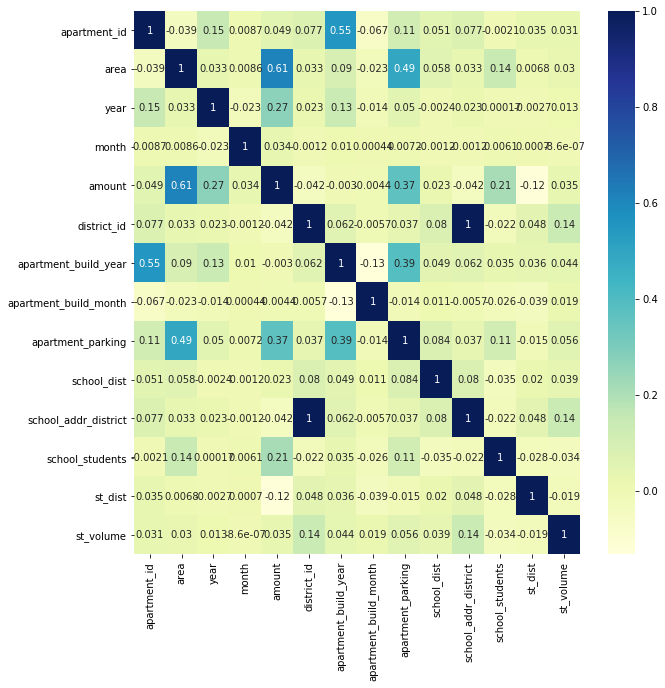

In [10]:
figure,ax1 = plt.subplots()
figure.set_size_inches(10,10)

sns.heatmap(df.corr(),annot=True,cmap='YlGnBu')

# 연도별 거래액



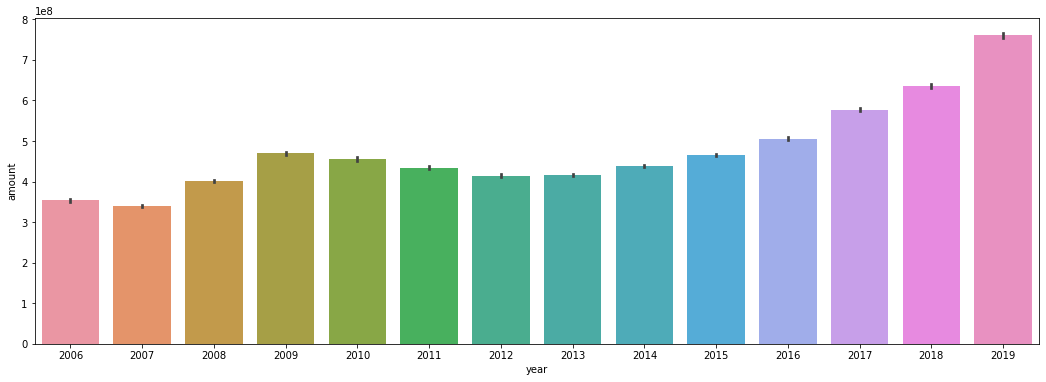

In [11]:
#2020년도의 경우 5월달까지의 거래액만 존재해서 제외
a = df[df['year']<2020]
figure,ax1 = plt.subplots()
figure.set_size_inches(18,6) 

sns.barplot(data=a,x="year",y="amount",ax=ax1)

- 2009년도부터 2013년까지의 실거래가가 감소하나, 2013년도부터 실거래가 증가

# 자치구별 거래액

- 실거래가를 자치구별로 나타내고, 이상치를 제거했다

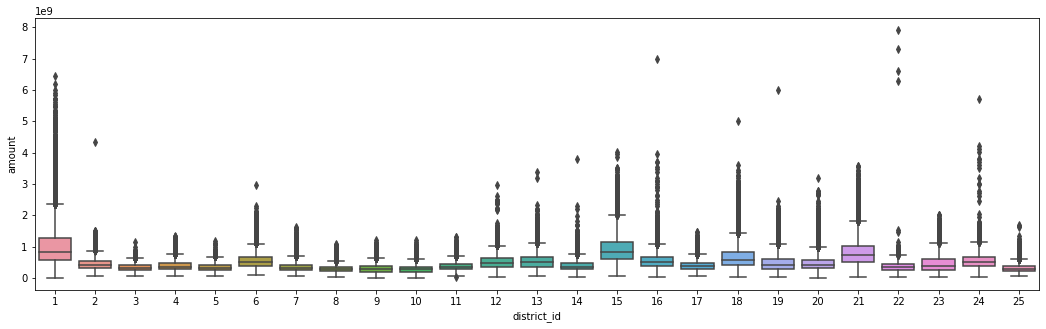

In [12]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5)

sns.boxplot(data=df,y='amount',x='district_id')

- 이상치는 동일 면적의 해당 아파트 거래가 한번인 경우 제거하지 않았다
- 해당 아파트에 대한 거래 정보가 없어지기 때문

In [13]:
#이상치 제거
df.drop(df[df['district_id']==2].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==6].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==12].sort_values(by='amount',ascending=False).head(5).index,inplace=True)
#df.drop(df[df['district_id']==13].sort_values(by='amount',ascending=False).head(2).index,inplace=True) 거래가 총 2번 이루어져서 제거 안함
df.drop(df[df['district_id']==14].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==16].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==18].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==19].sort_values(by='amount',ascending=False).head(1).index,inplace=True)
df.drop(df[df['district_id']==22].sort_values(by='amount',ascending=False).head(3).index,inplace=True)#신호아파트 면적97인 아파트의 경우 한번 거래가 이루어져 제거 안함
df.drop(df[df['district_id']==24].sort_values(by='amount',ascending=False).head(1).index,inplace=True)

In [14]:
# df[df['district_id']==22].sort_values(by='amount',ascending=False).head(4)[['apartment_name','area','amount']]

In [15]:
# df[(df['apartment_name']=='신호')&(df['area']==132)]

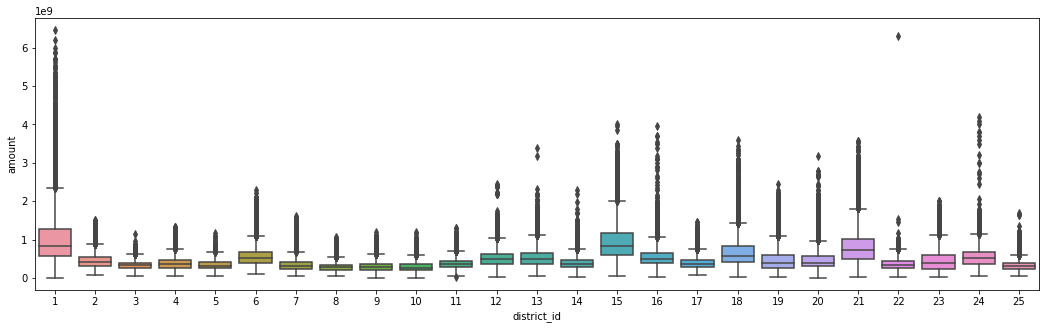

In [16]:
#이상치를 제거한 boxplot
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5)

sns.boxplot(data=df,y='amount',x='district_id')

- 이상치를 제거한 이후의 자치구별 실거래가 boxplot

# 학교정보

In [17]:
df['school_name'].nunique()

538

- 538개의 학교가 있으며, 초등학교 데이터만 존재 

In [18]:
sample = df[df['school_students']>0]
sample = sample.groupby(['school_name','year'])['amount'].mean().reset_index()
sample_2019 = sample[sample['year']==2019]
sample_2019.head()

,school_name,year,amount
13,서울가곡초등학교,2019,7.871852e+08
28,서울가동초등학교,2019,9.587981e+08
43,서울가락초등학교,2019,1.119956e+09
58,서울가산초등학교,2019,4.142600e+08
73,서울가양초등학교,2019,5.781785e+08


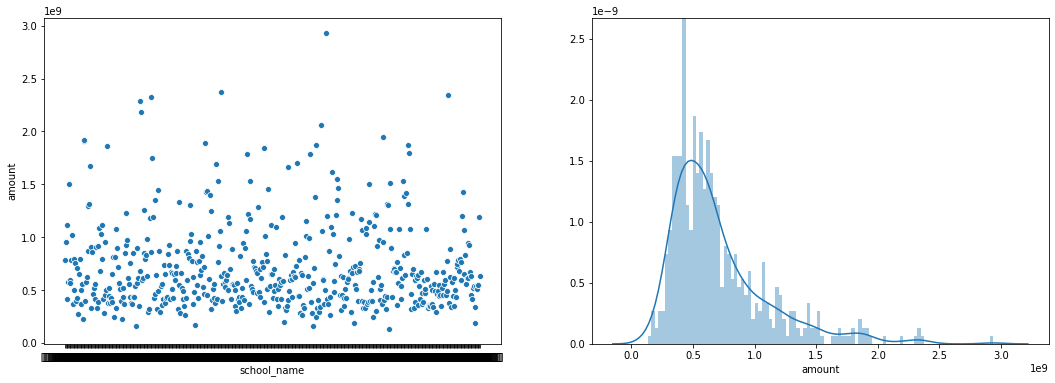

In [19]:
figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6) 

sns.scatterplot(sample_2019['school_name'],sample_2019['amount'],ax=ax1)
sns.distplot(sample_2019['amount'],ax=ax2,bins=100)

- 학교별 주변 아파트의 2019년도 가격 평균을 구하였을 때, 그 가격의 분포가 학교에 따라 다양한 값을 갖는다

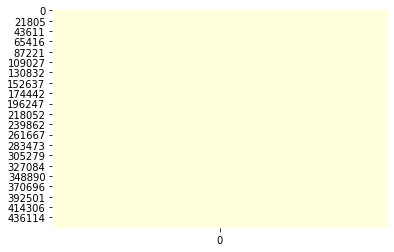

In [20]:
a = df['school_addr_district']==df['district_id']
a = pd.DataFrame(a)
sns.heatmap(a,cbar=False, cmap="YlGnBu")

- 'school_add_district'와'district_id' 값이 모두 동일 > 제거한다 
- 행정동의 경우, 동일한 지역에 대해 다른 명칭으로 표기되어 있음(노량진동 노량진로) > 제거한다

In [21]:
df['school_dist'].max()

29

- 아파트에서 가장 가까운 학교까지의 거리는 최대 도보 29분

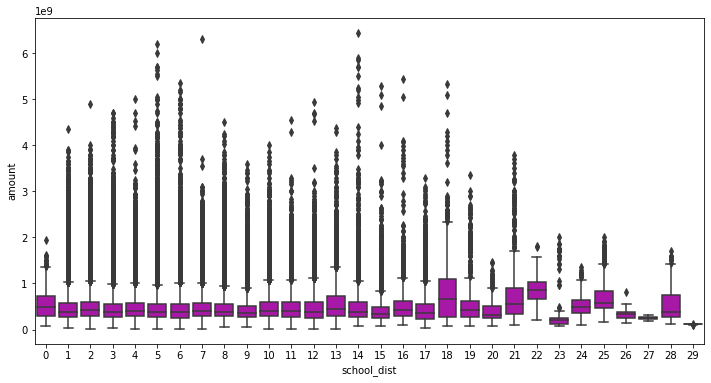

In [22]:
figure,ax1 = plt.subplots()
figure.set_size_inches(12,6) 

sns.boxplot(x="school_dist",y="amount",data=df,color="m",ax=ax1)

- 아파트에서 학교까지의 거리에 따른 amount값이 큰 차이를 보이지 않는다. 특히 17분 이하의 경우에는 거의 동일한 box plot을 갖는다 >>
제거
- heatmap의 0.023 수치에서도 확인 가능

In [23]:
ind = df[df['school_name']=='서울가산초등학교'].index
df2 = df.drop(ind)
a = df[df['school_students']==0].index
df2 = df2.drop(a)
#서울가산초등학교의 경우 데이터에 따라 금천구 구로구에 모두 속한다고 
#표기되어있음. 우선 제거한다
#학생수가 0인 경우 또한 우선 제거해서 분석

In [24]:
df2 = df2.groupby('school_name').mean()[['school_students','amount']].dropna()
df2 = pd.merge(df2,df[['district_name','school_name']],how='left',on='school_name').drop_duplicates()
df2.reset_index(inplace=True)
df2.head()
df2[df2['school_students']>2000] #학생수가 2000명 넘는 학교

,index,school_name,school_students,amount,district_name
101,85015,서울대도초등학교,2157.0,1.449975e+09,강남구


- 학생수가 2000명 넘는 학교는 한군데, 서울대도초등학교 >> 제외하고 분석

In [25]:
#대도초등학교 제외하고 분포 살펴보기
df2 = df2[df2['school_students']<2000]

- 자치구 세대수 대비 학교 학생수의 비율 구하기

In [26]:
df2.head()

,index,school_name,school_students,amount,district_name
0,0,서울가곡초등학교,879.0,4.794164e+08,강서구
1,562,서울가동초등학교,947.0,6.759128e+08,송파구
2,1769,서울가락초등학교,812.0,7.367314e+08,송파구
3,1984,서울가양초등학교,235.0,3.622789e+08,강서구
4,2738,서울가원초등학교,630.0,1.038202e+09,송파구


In [27]:
population = pd.read_excel("population.xlsx")
population.drop(['※ 매년 말일자 통계 현황','Unnamed: 4'],axis=1,inplace=True)
population.drop([0,1,2],inplace=True)
population.rename(columns={'Unnamed: 1':'district_name','Unnamed: 2':'총인구수','Unnamed: 3':'세대수'},inplace=True)

In [28]:
population['district_name'] = population.district_name.str.split(' ').str[1]
population['세대수'] = population.세대수.str.replace(',', '').astype('int64')

In [29]:
population.head()

,district_name,총인구수,세대수
3,종로구,"151,290",73947
4,중구,"126,171",62739
5,용산구,"228,670",110126
6,성동구,"300,889",135838
7,광진구,"351,350",164428


In [30]:
df1 = pd.merge(df2,population,how='left',on='district_name')
df1['ratio'] = 0.0
for ind in df1.index:
  a = float(df1['세대수'][ind])
  b = float(df1['school_students'][ind])
  df1['ratio'][ind] = b/a
df1[df1['ratio']>0.015] #제거

,index,school_name,school_students,amount,district_name,총인구수,세대수,ratio
334,269371,서울신용산초등학교,1668.0,1.160135e+09,용산구,"228,670",110126,0.015146


- ratio는 각 자치구별 세대수와 학교 학생 수의 비율을 나타낸 것
- ratio는 0.00038~0.015사이
- ratio가 0.015 이상인 학교는 한 사례다 > 제거한다  

In [31]:
df1 = df1[df1['ratio']<0.015]

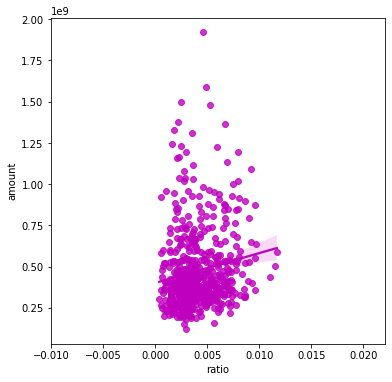

In [32]:
figure,ax1 = plt.subplots()
figure.set_size_inches(6,6) 

sns.regplot(x="ratio",y="amount",data=df1,color="m",ax=ax1)

- ratio가 클수록 아파트의 실거래가가 높아진다

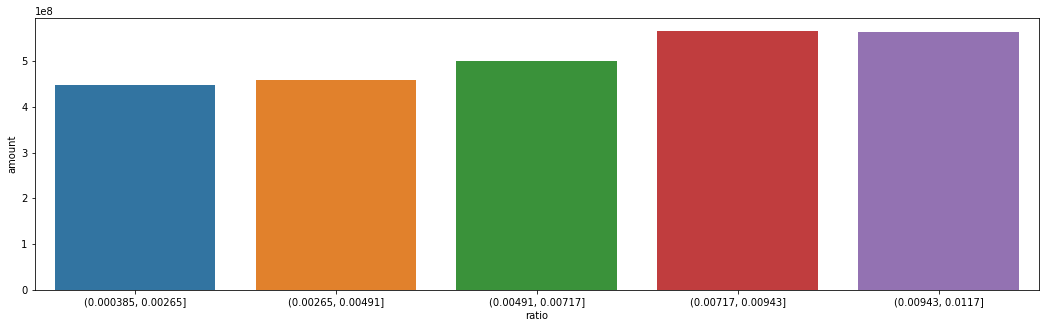

In [33]:
factor = pd.cut(df1.ratio,5)
a = df1.amount.groupby(factor).mean()
a = pd.DataFrame(a)
a = a.reset_index()


figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=a,x="ratio",y="amount",ax=ax1)

- 자치구 세대수 인구 대비 학교 학생수의 비율이 커질수록, amount가 커지는 경향

# 세대당 주차대수

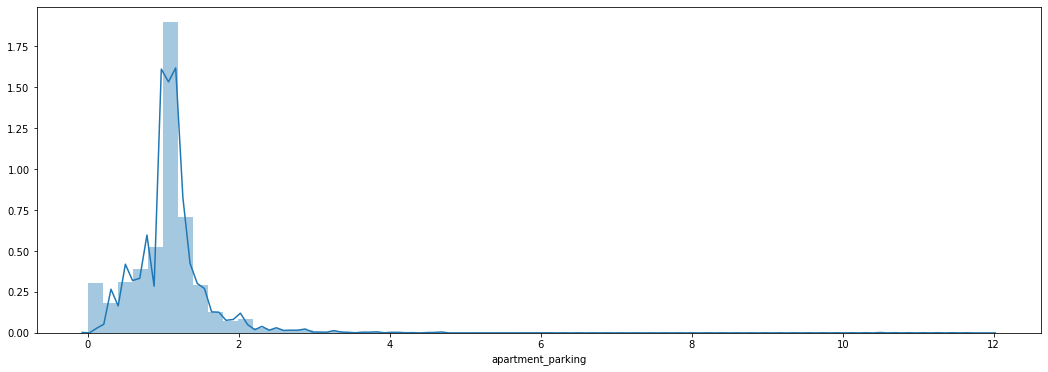

In [34]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,6) 
sns.distplot(df['apartment_parking'],ax=ax1,bins=60)

- 세대당 주차대수는 0~2대 사이에 주로 분포

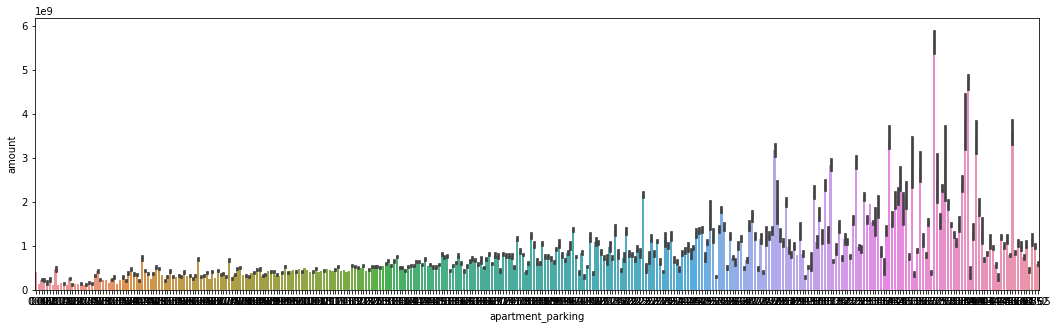

In [35]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=df,x="apartment_parking",y="amount",ax=ax1)

- 세대당 주차대수의 값이 커질수록 amount의 값이 점진적으로 우상향하는 것을 확인할 수 있다

# 건설

In [36]:
df['apartment_builder'].nunique()

2520

- 2520개의 건설사 존재

In [37]:
sample = df.groupby(['apartment_builder','year'])['amount'].mean().reset_index()
sample_2019 = sample[sample['year']==2019]
sample_2019.head()

,apartment_builder,year,amount
3,((주)심원디엔씨),2019,344000000.0
13,(유)25종합건설,2019,325000000.0
24,(유)동호에스제이종합개발,2019,280000000.0
32,(유)호원건설,2019,340000000.0
45,(조한종합),2019,509999999.0


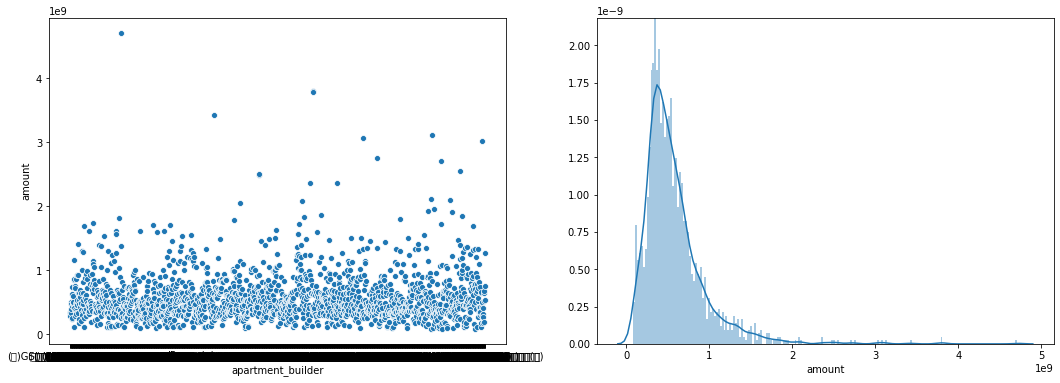

In [38]:
figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6) 

sns.scatterplot(sample_2019['apartment_builder'],sample_2019['amount'],ax=ax1)
sns.distplot(sample_2019['amount'],ax=ax2,bins=200)

- 시행사별 2019년 아파트 평균 가격을 구하였을 때, 10억 이하의 값으로 편중되어있다 > 제거한다 

In [39]:
sample_2019[sample_2019['amount']>1000000000].count()

apartment_builder    184
year                 184
amount               184
dtype: int64

- 10억 이상의 값을 가지는 경우는 7프로 이하

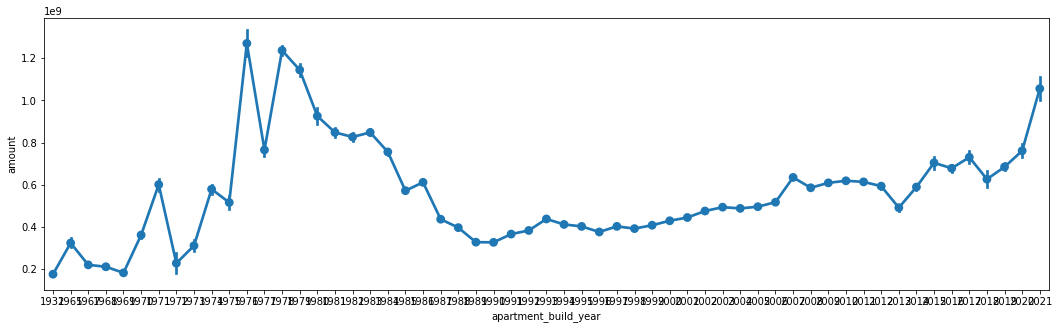

In [40]:
figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.pointplot(data=df,x="apartment_build_year",y="amount",ax=ax1)

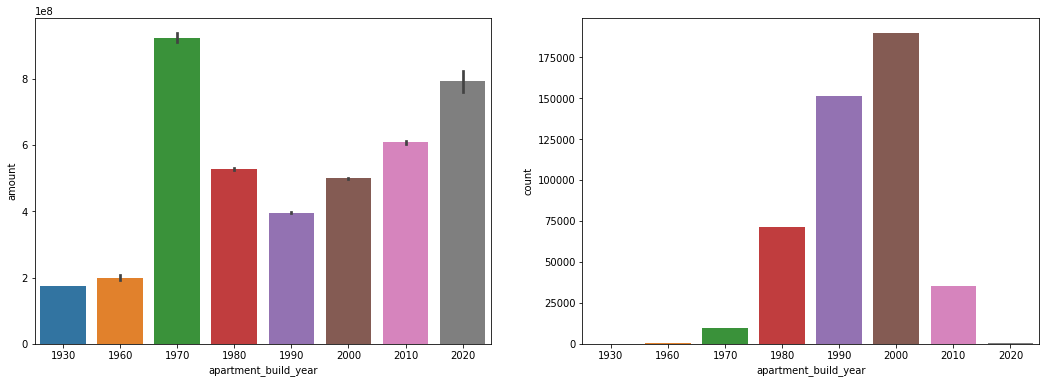

In [41]:
df['apartment_build_year'] = df['apartment_build_year'].apply(lambda x : x - x%10)
a = df['apartment_build_year'].value_counts()
a = pd.DataFrame(a)
a.reset_index(inplace=True)
a.rename(columns={'index':'apartment_build_year','apartment_build_year':'count'},inplace=True)


figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6) 

sns.barplot(data=df,x="apartment_build_year",y="amount",ax=ax1)
sns.barplot(data=a,x="apartment_build_year",y="count",ax=ax2)

- 1970, 2020년대에 지어진 아파트의 수가 적은거에 비해 amount의 평균이 높다
- 2000년대에 가장 많이 아파트가 지어졌지만, 그에 비해 amount의 평균이 낮음

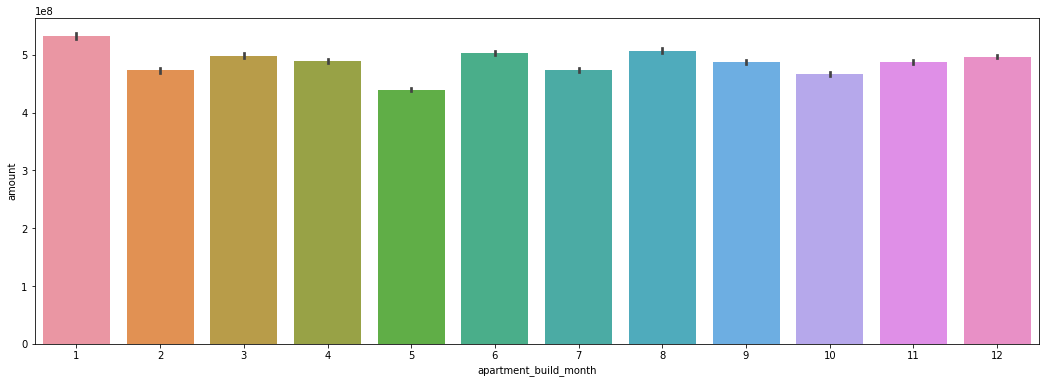

In [42]:
figure,ax = plt.subplots()
figure.set_size_inches(18,6) 

sns.barplot(data=df,x="apartment_build_month",y="amount")

- apartment_build_month 제거, amount와의 상관관계의 값이 0.04임을 heatmap에서도 확인 가능 

# 지하철역

In [43]:
df['st_name'].nunique()

296

In [44]:
sample = df.groupby(['st_name','year'])['amount'].mean().reset_index()
sample_2019 = sample[sample['year']==2019]
sample_2019.head()

,st_name,year,amount
13,4.19민주묘지역,2019,3.322311e+08
28,가락시장역,2019,1.131895e+09
43,가산디지털단지역,2019,3.877221e+08
58,가양역,2019,5.530393e+08
73,가오리역,2019,4.011351e+08


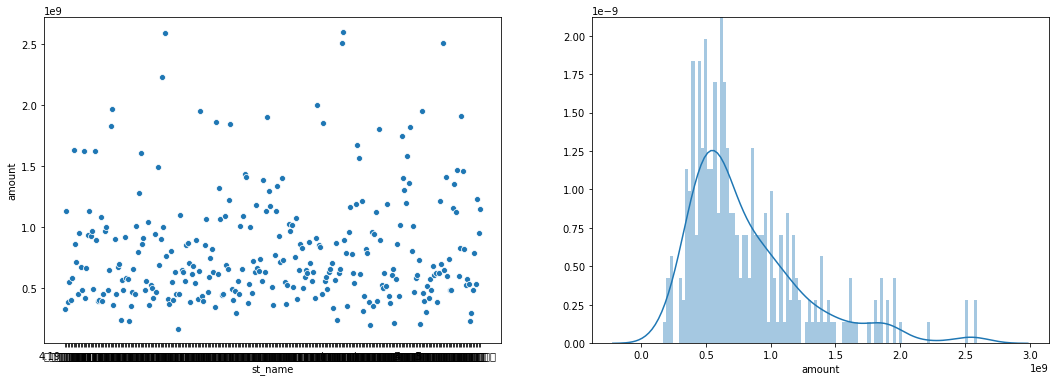

In [45]:
figure,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
figure.set_size_inches(18,6)

sns.scatterplot(sample_2019['st_name'],sample_2019['amount'],ax=ax1)
sns.distplot(sample_2019['amount'],ax=ax2,bins=100)

- 각 지하철역 근처 아파트의 2019년 거래가 평균을 살펴보았을 때, 가격의 분포가 역에 따라 다양한 값을 갖는다

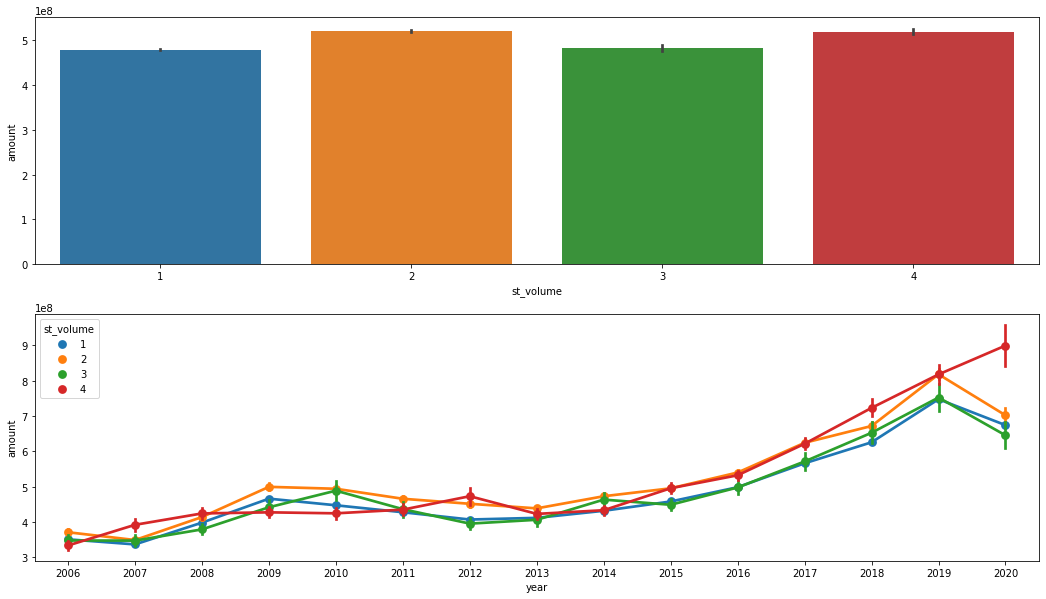

In [46]:
figure,(ax1,ax2) = plt.subplots(nrows=2,ncols=1)
figure.set_size_inches(18,10) 

sns.barplot(data=df,y='amount',x='st_volume',ax=ax1)
sns.pointplot(data=df,y='amount',x='year',hue='st_volume',ax=ax2)

- 환승역이 4개인 곳의 실거래가가 2014년도 이후부터 꾸준히 증가
- 환승역의 개수 별 거래액이 큰 차이를 보이지 않는다 > 제거 

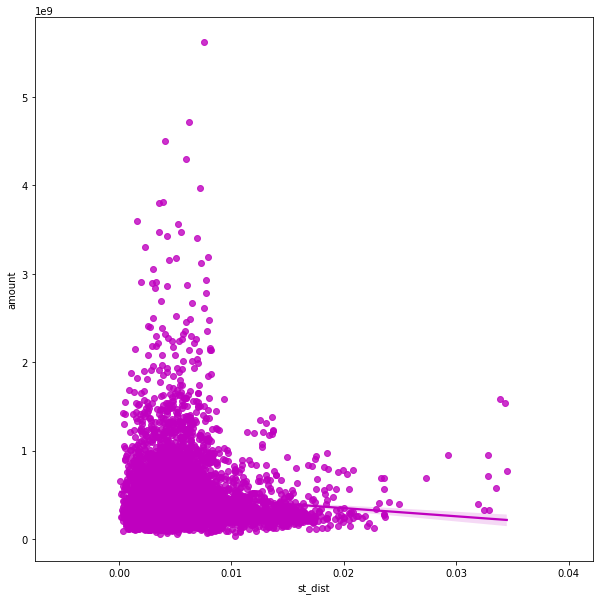

In [47]:
#지하철역과의 거리
a = df.groupby('st_dist').mean()['amount']
a = pd.DataFrame(a).reset_index()

figure,ax1 = plt.subplots()
figure.set_size_inches(10,10) 

sns.regplot(x="st_dist",y="amount",data=a,color="m",ax=ax1)

- 가까운 역까지의 거리와 거래액은 음의 상관관계를 보인다 
- 이번에는 거리를 구간별로 나눠서 살펴보자

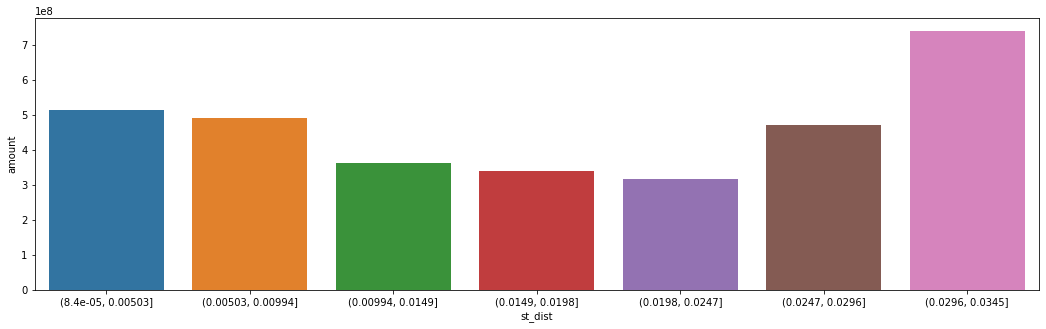

In [48]:
factor = pd.cut(df.st_dist,7)
a = df.amount.groupby(factor).mean()
a = pd.DataFrame(a)
a = a.reset_index()

figure,ax1 = plt.subplots()
figure.set_size_inches(18,5) 

sns.barplot(data=a,x="st_dist",y="amount",ax=ax1)

- 거리가 0.0247 이하인 경우 지하철역에서 거리가 가까울수록 거래가가 비싸지만, 0.0247보다 큰 경우에는 양의 상관관계를 보인다
- 지하철역과 거리가 가장 먼 곳이 가장 높은 평균 거래가를 갖는다(평창동?을 예로 들 수 있을거 같다..자가용 이용..)

In [49]:
df[df['st_dist']>0.0296].head()

,apartment_id,area,period,year,month,amount,amount_original,district_id,apartment_addr_town,apartment_builder,...,apartment_name,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume
436478,3826,111,2019.01,2019,1,575000000,"5억 7,500",23,평창동,롯데건설주식회사,...,롯데낙천대,종로구,서울세검정초등학교,24,23,세검정로9길,864.0,경복궁역,0.033561,1
436479,3826,111,2018.03,2018,3,570000000,"5억 7,000",23,평창동,롯데건설주식회사,...,롯데낙천대,종로구,서울세검정초등학교,24,23,세검정로9길,864.0,경복궁역,0.033561,1
436480,3826,111,2017.10,2017,10,500000000,5억,23,평창동,롯데건설주식회사,...,롯데낙천대,종로구,서울세검정초등학교,24,23,세검정로9길,864.0,경복궁역,0.033561,1
436481,3826,111,2017.08,2017,8,509999999,"5억 1,000",23,평창동,롯데건설주식회사,...,롯데낙천대,종로구,서울세검정초등학교,24,23,세검정로9길,864.0,경복궁역,0.033561,1
436482,3826,111,2017.06,2017,6,529000000,"5억 2,900",23,평창동,롯데건설주식회사,...,롯데낙천대,종로구,서울세검정초등학교,24,23,세검정로9길,864.0,경복궁역,0.033561,1


- 실제로 아파트와 지하철과의 거리가 0.0296보다 먼 동네는 평창동이었다..

- 'apartment_build_month' 'school_addr_district' 'school_addr_town' 'school_dist' 'apartment_builder 'apartment_floor_min', 'apartment_floor_max' 'st_volume' 제거
- 'apartment_id' 'area' 'period' 'year' 'month' 'amount' 'district_id' 'apartment_addr_town' 'apartment_build year' 'apartment_parking' 'apartment_name' 'district_name' 'school_name' 'school_students' 'st_name' 'st_dist' 포함

In [50]:
df = df.drop(['apartment_build_month','school_addr_district','school_addr_town','school_dist','apartment_builder','apartment_floor_min','apartment_floor_max','st_volume'],axis=1)
df.head()

,apartment_id,area,period,year,month,amount,amount_original,district_id,apartment_addr_town,apartment_build_year,apartment_parking,apartment_name,district_name,school_name,school_students,st_name,st_dist
0,8928,160,2020.02,2020,2,2060000000,"20억 6,000",1,개포동,2000,2.36,LG개포자이,강남구,서울대진초등학교,316.0,학여울역,0.002592
1,8928,160,2020.01,2020,1,2030000000,"20억 3,000",1,개포동,2000,2.36,LG개포자이,강남구,서울대진초등학교,316.0,학여울역,0.002592
2,8928,160,2019.11,2019,11,1950000000,"19억 5,000",1,개포동,2000,2.36,LG개포자이,강남구,서울대진초등학교,316.0,학여울역,0.002592
3,8928,160,2019.10,2019,10,1939999999,"19억 4,000",1,개포동,2000,2.36,LG개포자이,강남구,서울대진초등학교,316.0,학여울역,0.002592
4,8928,160,2019.07,2019,7,1739999999,"17억 4,000",1,개포동,2000,2.36,LG개포자이,강남구,서울대진초등학교,316.0,학여울역,0.002592
